In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pylab as plt

import stretchablecorr as sc

In [3]:
cube, image_names = sc.load_image_sequence('./images/HS2/')

Load images from ./images/HS2/...
Image sequence:
 23 frames , 1392*1024 pixels , memory size: 250 Mo
 images: 00p000001.TIF, 00p100012.TIF, 00p200023.TIF , ... ,  55p000267.TIF


grid size: 12x9
 i.e. 108 points


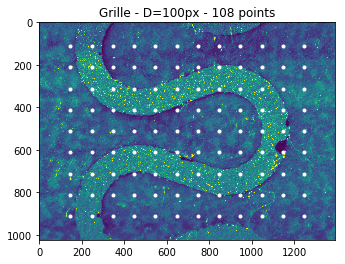

In [4]:
# ==================
#  Define the grid
# ==================

grid_spacing = 100 
grid_margin = 105
# ----
grid = sc.build_grid(cube.shape[1:], margin=grid_margin, spacing=grid_spacing)
points = np.stack( (grid[0].flatten(), grid[1].flatten()), axis=-1 )

# Graph the grid
plt.figure();
plt.title(f'Grille - D={grid_spacing}px - {points.shape[0]} points');
sc.plot_grid_points(grid, background=cube[0],
                    color='white', markersize=3)

In [6]:
def _triangulate_xy(I, J, K, xy, params):
    
    u_ij, err = sc.get_shifts(I, J, *xy, **params)

    xy_j = xy + u_ij
    u_jk, err = sc.get_shifts(J, K, *xy_j, **params)
    x_ijk = xy_j + u_jk

    u_ik, err = sc.get_shifts(I, K, *xy, **params)
    x_ik = xy + u_ik

    d = np.sqrt(np.sum((x_ik - x_ijk)**2))
    return d, max(np.sqrt(np.sum(u_ij**2)),
                  np.sqrt(np.sum(u_jk**2)),
                  np.sqrt(np.sum(u_ik**2)))


def triangulate(I, J, K, points, params):
    
    errors = []
    distances = []
    for xy in points:
        try:
            err, d = _triangulate_xy(I, J, K, xy, params)
            errors.append(err)
            distances.append(d)
        except ValueError:
            pass
        
    return np.array(errors), np.array(distances)

def construct_key(p):
    name = f"{p['window_half_size']}px"
    if p['coarse_search']:
        name += '_coarse'
    if p['phase']:
        name += '_phase'
    else:
        name += '_CC'
    name += '_' + p['method']
    return name

In [8]:
results = {}
ijk = 0, 2, 4
ijk = 17, 18, 19
IJK = [cube[idx] for idx in ijk]

coarse_search = True
params = {'window_half_size': 40,
          'coarse_search':coarse_search,
          'phase': False,
          'method':'opti' }
results[construct_key(params)] = triangulate(*IJK, points, params)

params = {'window_half_size': 15,
          'coarse_search':coarse_search,
          'phase': False,
          'method':'opti' }
results[construct_key(params)] = triangulate(*IJK, points, params)


params = {'window_half_size': 20,
          'coarse_search':coarse_search,
          'phase': True,
          'method':'opti' }
results[construct_key(params)] = triangulate(*IJK, points, params)

params = {'window_half_size': 40,
          'coarse_search':coarse_search,
          'phase': True,
          'method':'opti' }
results[construct_key(params)] = triangulate(*IJK, points, params)

params = {'window_half_size': 7,
          'coarse_search':coarse_search,
          'phase': False,
          'method':'opti' }
results[construct_key(params)] = triangulate(*IJK, points, params)

sorted_results = sorted(list(results.items()), key=lambda x:np.mean(x[1][0]))

print('\n'.join([f'{k[0]:<20} {np.mean(k[1][0]): 7.2f} {np.mean(k[1][1])}'
       for k in sorted_results]))

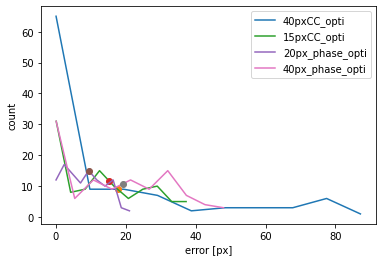

In [90]:
for key, (errors, distances) in results.items():
    d_mean = np.mean(errors)
    n, bins = np.histogram(errors);
    plt.plot(bins[:-1], n, label=key)
    
    plt.plot(d_mean, np.interp(d_mean, bins[:-1], n), 'o')

plt.legend(); plt.xlabel('error [px]')
plt.ylabel('count');

In [104]:
print('\n'.join([f'{k[0]:<20} {np.mean(k[1][0]): 7.2f} {np.mean(k[1][1])}'
       for k in sorted_results]))

15px_coarseCC_opti     13.92 29.910678116130637
40px_coarseCC_opti     14.69 32.93321053611752
40px_coarse_phase_opti   14.77 31.255842745998883
20px_coarse_phase_opti   16.15 30.535217185822052


In [88]:
print('\n'.join([f'{k[0]:<20} {np.mean(k[1][0])}'
       for k in sorted_results]))

40pxCC_opti          0.13291181977007294
40px_phase_opti      0.1499698289412096
15pxCC_opti          0.18231776868004598
20px_phase_opti      0.28273282830294405


In [68]:
plt.imshow(distances_grid);
plt.colorbar();

NameError: name 'distances_grid' is not defined

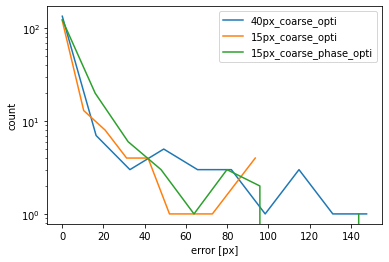

In [45]:
results = {}
ijk = 17, 18, 19
IJK = [cube[idx] for idx in ijk]

params = {'window_half_size': 40,
          'coarse_search':True,
          'phase': False,
          'method':'opti' }

results[construct_key(params)] = triangulate(*IJK, points, params)

params = {'window_half_size': 15,
          'coarse_search':True,
          'phase': False,
          'method':'opti' }

results[construct_key(params)] = triangulate(*IJK, points, params)

params = {'window_half_size': 15,
          'coarse_search':True,
          'phase': True,
          'method':'opti' }

results[construct_key(params)] = triangulate(*IJK, points, params)

for key, distances in results.items():
    n, bins = np.histogram(distances);
    plt.semilogy(bins[:-1], n, label=key)
    
plt.legend(); plt.xlabel('error [px]')
plt.ylabel('count');

## windows size choice

In [34]:
results = {}
#ijk = 17, 18, 19
ijk = 0, 8, 16
IJK = [cube[idx] for idx in ijk]

windows_size_span = [5, 10, 15, 20, 30, 40, 60, 80]

coarse_search = True
for whs in windows_size_span:
    print(whs)
    params = {'window_half_size': whs,
              'coarse_search':coarse_search,
              'phase': False,
              'method':'opti' }
    results[construct_key(params)] = triangulate(*IJK, points, params)

5
10
15
20
30
40
60
80


In [35]:
sorted_results = sorted(list(results.items()), key=lambda x:np.mean(x[1][0]))

print('\n'.join([f'{k[0]:<20} {np.mean(k[1][0]): 7.2f} {np.mean(k[1][1])}'
       for k in sorted_results]))

30px_coarse_CC_opti     3.72 28.56224737617137
80px_coarse_CC_opti     4.48 23.69392857047381
15px_coarse_CC_opti     4.64 28.369004734935906
20px_coarse_CC_opti     4.91 27.874181485847988
10px_coarse_CC_opti     5.10 28.519422863760852
40px_coarse_CC_opti     5.13 29.05337778831928
60px_coarse_CC_opti     5.14 28.499171364393945
5px_coarse_CC_opti      5.97 27.465819493463


ijk = 0, 2, 4

    40px_coarse_CC_opti     0.09 2.259973140522304
    30px_coarse_CC_opti     0.10 2.2622871765443
    20px_coarse_CC_opti     0.12 2.261829636143824
    15px_coarse_CC_opti     0.13 2.2634306646659104
    10px_coarse_CC_opti     0.14 2.26663557199468
    5px_coarse_CC_opti      0.27 2.298498600568171

    40px_coarse_phase_opti    0.15 2.2654455306205796
    30px_coarse_phase_opti    0.16 2.264311597123281
    20px_coarse_phase_opti    0.20 2.3456869633174007
    15px_coarse_phase_opti    0.21 2.3517071681117967
    10px_coarse_phase_opti    0.31 2.389567565122548
    5px_coarse_phase_opti    0.58 2.3683886448966254


ijk = 17, 18, 19

    20px_coarse_CC_opti    12.61 31.070749300731286
    10px_coarse_CC_opti    13.57 29.295575670259872
    30px_coarse_CC_opti    13.62 31.880018045480217
    15px_coarse_CC_opti    13.92 29.910678115302705
    40px_coarse_CC_opti    14.69 32.93321053537991
    5px_coarse_CC_opti     16.87 29.68630756901744


    5px_coarse_phase_opti   13.49 27.914897056628146
    40px_coarse_phase_opti   14.77 31.255842745998883
    10px_coarse_phase_opti   14.87 28.596095838056392
    30px_coarse_phase_opti   15.20 30.92854706730653
    20px_coarse_phase_opti   16.15 30.535217185822052
    15px_coarse_phase_opti   16.28 30.15249085909452


In [26]:
results

{'5px_coarse_phase_opti': (array([0.15605253, 3.43746451, 1.31822246, 0.12025068, 0.15166513,
         0.20313105, 0.19375451, 0.12767603, 0.51301288, 0.13303454,
         2.90647874, 0.25624548, 0.11577166, 0.23919705, 0.56016769,
         0.65833142, 2.76731786, 0.06869799, 0.17444817, 0.10676588,
         0.15381765, 0.30667947, 0.9436287 , 1.04431852, 0.03801057,
         2.01249974, 0.04713827, 2.32732379, 1.02447077, 0.06564012,
         0.27462757, 0.14303113, 0.14962942, 0.04647105, 0.39569453,
         1.6442606 , 0.83942252, 0.51178693, 0.09222676, 0.32942204,
         1.13096865, 0.13294132, 0.09946304, 0.42150253, 0.6220116 ,
         0.14762309, 0.10044892, 0.24953748, 0.11288377, 0.4133627 ,
         1.77087102, 0.17255768, 0.06103048, 0.06459148, 0.25978686,
         1.70429931, 1.00579342, 0.33426853, 0.13628123, 0.77822778,
         0.2753024 , 0.33918378, 0.09063071, 0.20089951, 0.26432658,
         0.64382433, 3.91104762, 0.20140142, 0.2028203 , 0.06289126,
         